<a href="https://colab.research.google.com/github/sush2004/Python/blob/main/Python_CA2_10550452.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Display the total number of rows and column.***

Total number of rows: 38556.
Total number of rows: 11.

***Display non-null and null value count by column.***

              Not_Null_Count  Null_Count
Date                   38556           0
Station Area           38556           0
Description            38556           0
TOC                    38556           0
ORD                    38556           0
MOB                    37311        1245
IA                     30962        7594
LS                     38556           0
AH                       153       38403
MAV                    38530          26
CD                     38530          26

***Display null value count for all columns.***

Total number of null value for all the columns: 47294

***Display total number of call outs by Station Area.***

      Station Area  Total Call Outs
0       Balbriggan              688
1   Blanchardstown             2089
2    Dolphins Barn             4018
3       Donnybrook             1787
4

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


Record 147 inserted into table FireBrigadeAndAmbulanceCallOuts.

***Plot the call out based on station area after ETL operation***



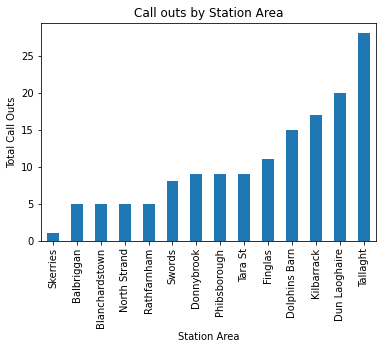

In [ ]:
import pandas as pd
import datetime as date
import sqlite3
import matplotlib.pyplot as plt

df=pd.read_csv('FireBrigadeAndAmbulanceCallOuts.csv')

def record_count():
  print('***Display the total number of rows and column.***\n')
  #counting number of rows
  rows = len(df.axes[0])
  print(f'Total number of rows: {rows}.')
  #counting number of columns
  cols = len(df.axes[1])
  print(f'Total number of rows: {cols}.')

def display_data():
  print('\n***Display non-null and null value count by column.***\n')
  #count not null in each column
  not_null=df.count()
  #count null in each column
  null_col= df.isnull().sum()
  df1=pd.DataFrame([not_null, null_col])
  df1=df1.transpose()
  df1.columns=['Not_Null_Count','Null_Count']
  return df1

def null_for_col():
  print('\n***Display null value count for all columns.***\n')
  null_col= df.isnull().sum()                                                   #computing null value by column
  null_col=null_col.sum()
  print(f'Total number of null value for all the columns: {null_col}')

def couts_by_station():
  print('\n***Display total number of call outs by Station Area.***\n')
  station_by=df.groupby('Station Area').count()['TOC']
  call_outs=station_by.reset_index(name='Total Call Outs')
  return call_outs

def couts_by_date_station():
  print('\n***Display total number of call outs by Date and Station Area.***\n')
  tot_call=df.groupby(['Date','Station Area']).count()['TOC']      ###check for [TOC] reference col
  tot_call=tot_call.reset_index(name='Total Call Outs')
  return tot_call

def condition_desc():
  print('\n***Display total number of call outs by Station Area and Date where the description is either Fire Car or Fire Alarm.***\n')
  df_filter=df[df['Description'].isin(['Fire ALARM','Fire CAR'])]
  res_df=df_filter.groupby(['Station Area', 'Date']).count()['TOC']
  res_df=res_df.reset_index(name='Total Call Outs')
  return res_df

def data_transform():
  print('\n***Total not null recrods count before transformation by column.\n***')
  print(df.count())
  print('\nTransformation initiated...\n')
  data=df.replace(',','')
  print('Replaced all , with empty string.')
  data=data.replace('-','')
  print('Replaced all - with empty string.')
  data=data.dropna(subset=['AH','MAV','CD'])
  print('Dropped rows for the columns(AH, MAV, CD) where atleast one row value is NULL.')
  emptyAH=data[data['AH']==''].index
  data=data.drop(emptyAH)
  print('Dropped row for empty string from AH.')
  emptyMAV=data[data['MAV']==''].index
  data=data.drop(emptyMAV)
  print('Dropped row for empty string from MAV.')
  emptyCD=data[data['CD']==''].index
  data=data.drop(emptyCD)
  print('Dropped row for empty string from CD.')
  data=data.drop_duplicates(keep="first")
  print('Dropped duplicate rows except for the first occurrence')
  print('\n***Final not null Record count after transformation by column***\n')
  print(data.count())
  toc=pd.to_datetime(data['TOC'])
  ord=pd.to_datetime(data['ORD'])
  diff=min(ord-toc)
  print(f'\nThe minimum time difference between TOC and ORD : {diff}')
  return data

#function to create database and table
def create_db():
  print('\n***Database creation***')
  db = sqlite3.connect("Migration.db")
  print('Connection established!!!')
  db.execute("drop table if exists FireBrigadeAndAmbulanceCallOuts")
  try:
    #create the table
    db.execute("create table FireBrigadeAndAmbulanceCallOuts(Date DATE, [Station Area] text,Description text, TOC text, ORD text, MOB text,IA text,LS text,AH text, MAV text, CD text)")
    print('Table FireBrigadeAndAmbulanceCallOuts Created.')
  except:
    print("Table already exists !!")

#function to insert data into database
def insert_db(data):
  create_db()
  db = sqlite3.connect('Migration.db')
  print('Target connection established & ready to insert data.!!')
  #assign table name to a variable
  temp = 'FireBrigadeAndAmbulanceCallOuts'
  data.to_sql(temp, db, if_exists='replace',index=False)
  db.commit()
  #get the count from the table
  record_count=pd.read_sql('select count(*) as c from FireBrigadeAndAmbulanceCallOuts',db)
  #Print the total records inserted.
  print('Record {} inserted into table FireBrigadeAndAmbulanceCallOuts.\n'.format(record_count['c'][0]))

def plot_data():
  conn = sqlite3.connect('Migration.db')
  #select the data from table
  result = pd.read_sql('SELECT * FROM FireBrigadeAndAmbulanceCallOuts', conn)
  print('***Plot the call outs based on station area after ETL operation***\n')
  plot_station_data= result.groupby('Station Area').count()['TOC']              #group by station area to get the total call out
  plot_station_data.sort_values().plot(kind='bar')                              #plot the bar chart based on the above data
  #create the title
  plt.title('Call outs by Station Area')
  #create the yaxis label
  plt.ylabel('Total Call Outs')

if __name__=="__main__":
  record_count()
  print(display_data())
  null_for_col()
  print(couts_by_station())
  print(couts_by_date_station())
  print(condition_desc())
  insert_db(data_transform())
  plot_data()




